# ANOVA

ANOVA stands for Analysis of Variance and is a method used to compare means of more than 2 samples. For one and two samples, we have the t-tests for 1 and 2 samples (which make normality and equal variance assumptions). The approach followed in ANOVA is to compute the variation within a subgroup, and the difference in the variation between subgroups. This approach is known as the sum of squares and mean squares methods and uses a statistic called the F-statistic to do this comparison.

ANOVA makes the following assumptions:
1. The data is normally distributed in each sample
2. The variances of all samples are comparable (or are the same)

In order to make such comparisons, we run a multiple variance test after running the standard normality tests, to check whether all samples come from populations with the same variance.

## ANOVA Hypothesis test

Recall that for a 1 sample t-test, the default (or Null) and alternate hypotheses were:

$$H_0: \mu = k$$
$$H_a: \mu \neq k$$

This is subject to the sample coming from a normally distributed population.

Similarly, for the 2-sample t-test, the hypotheses were:

$$H_0: \mu_1 = \mu_2$$
$$H_a: \mu_1 \neq \mu_2$$

This hypothesis can be tested effectively if the following assumptions are true:
* Samples 1 and 2 both come from normally distributed populations
* Samples 1 and 2 both have equal variances (variance confidence intervals overlap)

ANOVA can be seen as an extension of the t-tests for comparing means. The same assumptions as for the 2-sample test will apply. If these assumptions are verified, we can conduct the following hypothesis test:

$$H_0: \mu_1 = \mu_2 = \mu_3 $$
$$H_a: \mu_1 \neq \mu_2 = \mu_3$$
or
$$H_a: \mu_1 = \mu_2 \neq \mu_3$$

i.e., the alternate hypothesis of ANOVA is that **at least one of the means is different from the others**.


## Problem Description

The average wait time in five different counters at a fast food chain is to be analyzed. The analyst hopes to discover whether any differences exist between the performance of different counters. There are five different self-service counters, where staff vend dishes purchased by customers. The wait time for each customer is calculated from the time they arrive at the restaurant, to the time they receive their dish. This includes the time taken to place the order, and the time taken to prepare orders. Wait times are measured in minutes.

In [130]:
import numpy as np
import random
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Reading and understanding the data

In this case, the data (as a CSV) is imported into Pandas and studied to understand some key statistics. We can also construct plots of the data.

In [131]:
times = pd.read_csv("waittimes.csv")
times.head()

,counter1,counter2,counter3,counter4,counter5
0,5.5,4.5,4.9,5.3,4.7
1,5.0,4.5,4.8,5.4,5.0
2,4.9,5.4,5.1,3.8,6.3
3,5.3,4.2,4.4,4.4,5.2
4,3.5,5.4,5.1,4.6,5.8


In [132]:
times.describe()

,counter1,counter2,counter3,counter4,counter5
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,5.092000,5.121000,5.113000,4.968000,5.559000
std,0.450965,0.591744,0.479405,0.584804,0.928896
min,3.500000,3.400000,3.700000,3.600000,3.000000
25%,4.900000,4.700000,4.800000,4.500000,4.975000
50%,5.100000,5.200000,5.100000,5.000000,5.700000
75%,5.400000,5.600000,5.400000,5.400000,6.125000
max,6.000000,6.500000,6.700000,6.300000,8.500000


The data in this case seems to have 100 customers' wait times recorded, and the mean, min/max and key statistics of the data are shown, by counter.

## Plotting and visualizing the data

Using Pandas' built in plotting methods, we can quickly construct plots and analyse the data set.

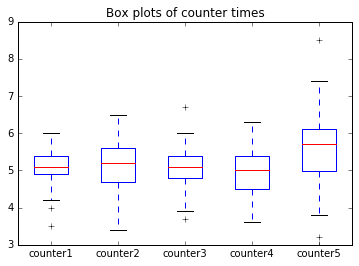

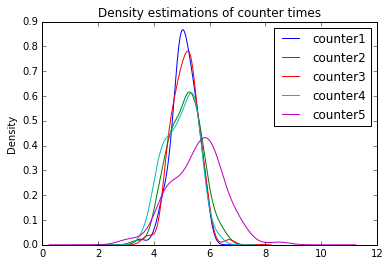

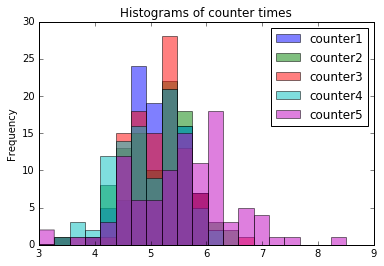

In [133]:
times.plot(kind = "box", title = "Box plots of counter times")
times.plot(kind = "kde", title = "Density estimations of counter times")
times.plot(kind = "hist", alpha = 0.5, bins = 20, title = "Histograms of counter times") #can set alpha blending value for transparency
plt.show()

The data from each counter seems to show median values between 3 and 9 minutes. The histogram reveals that some counters (like counter 5) have a high spread, indicating large variability in the process followed at the counter. In some other counters, the variability is far lesser, like in counter 1. The density plot reveals that the data from counter 5 shows a higher mean and large variability. Also, counter 2 and counter 4 seem to be very comparable in performance and mean values, from the kernel density plot.



## Checking Normality

We define a function to calculate the AD test statistic and use this to compute the significance of the result in each case.

In [134]:
def isnormal(data):
    result = sp.stats.anderson(data, dist = "norm")
    for x in zip(result.significance_level, result.critical_values):
        if(result.statistic > x[1]):
            print "Alternate hypothesis of normality test has a significance level of ",x[0], "% for this data."
        else:
            continue


Once the function has been constructed, we can check whether the data from all counters in the restaurant are normally distributed. Counters that do not have normally distributed data are considered to have a different process.

In [135]:
isnormal(times["counter1"])

In [136]:
isnormal(times["counter2"])

In [137]:
isnormal(times["counter3"])

In [138]:
isnormal(times["counter4"])

Alternate hypothesis of normality test has a significance level of  15.0 % for this data.
Alternate hypothesis of normality test has a significance level of  10.0 % for this data.
Alternate hypothesis of normality test has a significance level of  5.0 % for this data.
Alternate hypothesis of normality test has a significance level of  2.5 % for this data.


In [139]:
isnormal(times["counter5"])

We see that for one counter, we have a distinctly different process (which is not normally distributed with a 15% significance level. For the remaining 4 processes, we can do an ANOVA study, and compare means. Our next step is to compare variances. We can do this using the test for equal variances.

## Tests for Equal Variances

In [140]:
print stats.bartlett(times["counter1"], times["counter2"], times["counter3"], times["counter4"], times["counter5"])
print stats.levene(times["counter1"], times["counter2"], times["counter3"], times["counter4"], times["counter5"])

BartlettResult(statistic=71.185617955105002, pvalue=1.2753671136551051e-14)
LeveneResult(statistic=14.614257615390764, pvalue=2.7236471256931584e-11)


The Bartlett and Levene tests for equal variances also fail, because the p-value in both cases is extremely low, indicating a very slim chance of Type 1 error when we reject the null hypothesis. We can further confirm this by plotting the confidence intervals for the variances.

In [142]:
print "Variances of data, counters 1 thru 5: "
print sp.var(times["counter1"])
print sp.var(times["counter2"])
print sp.var(times["counter3"])
print sp.var(times["counter4"])
print sp.var(times["counter5"])

Variances of data, counters 1 thru 5: 
0.201336
0.346659
0.227531
0.338576
0.854219


Observe that the boxplot (which gives us an idea of the variability in the data) also agrees with these assessments of the variance. For counters 4 and 5, the boxes seem to be wider, and for the others, they're narrower. The reason we conduct the test, however, is because it computes confidence intervals. The above variance calculations are point estimates and don't consider the variability in the data set. The variability is usually a powerful indicator of where the population variance may lie.

## One Way ANOVA

One Way ANOVA for the first three counters (which were all normally distributed, and showed similar variance) is below.

In [156]:

#Comparing means of counters 1 to 3
counters1to3 = stats.f_oneway(times["counter1"], times["counter2"], times["counter3"])
print "Comparing counters 1-3:"
print "P-value : ",counters1to3.pvalue, "\tF-statistic: ", counters1to3.statistic


#Comparing means of counters 1 to 4
counters1to4 = stats.f_oneway(times["counter1"], times["counter2"], times["counter3"], times["counter4"])
print "\nComparing counters 1-4:"
print "P-value : ",counters1to4.pvalue, "\tF-statistic: ", counters1to4.statistic


#Comparing means of all counters
counters1to5 = stats.f_oneway(times["counter1"], times["counter2"], 
                              times["counter3"], times["counter4"], times["counter5"])
print "\nComparing counters 1-5:"
print "P-value : ",counters1to5.pvalue, "\tF-statistic: ", counters1to5.statistic


Comparing counters 1-3:
P-value :  0.917697767916 	F-statistic:  0.0859120132658

Comparing counters 1-4:
P-value :  0.144480842723 	F-statistic:  1.81145711973

Comparing counters 1-5:
P-value :  6.18627770748e-10 	F-statistic:  12.8166739571


### Making sense of the p-values and F-statistics

The p-values answer the following question in ANOVA:

*"If all the populations really have the same mean (all counters really have the same wait time), what is the chance that random sampling would result in means as far apart (or more so) as observed in this data set?"*

**P-value interpretation each set of results:**

* **Counters 1-3**: If all of the first three counters really have the same population mean, there is a 91.7% chance that random sampling would result in the means of those three samples as far as apart (or more so) as observed in this data set.

* **Counters 1-4**: If all of the first four counters really have the same population mean, there is a 14.4% chance that random sampling would result in the means of those three samples as far as apart (or more so) as observed in this data set.

* **Counters 1-5**: If all counters really have the same population mean, there is a $6\times10^{-8} \% $ (or... a very, very, very low) chance that random sampling would result in the means of those three samples as far as apart (or more so) as observed in this data set.

### Interpreting the F-statistic values:

$$F_{stat} = \frac {Mean\ square\ of\ factors}{Mean\ square\ of\ errors}$$

* The higher the F-statistic, the greater the chance that you have a statistically significant result
* p-values are computed based on the f-statistic and a critical value on the F-distribution
* If we expect the null hypothesis to be a model of the true state, the experiment should give us a low F-statistic value.
* Conversely, if we are testing for a significant result, we should look for a high value of F-statistic.
* For most ANOVA models, an F-statistic of >15 indicates that the mean square of the factors is much greater than the mean squared of errors.


Observe how in the above data set, the experiment for Counters 1-3 returned a low F-statistic, while for the other two, we got relatively higher F-statistic values. An F-statistic value of 1 means the mean square values of factors and errors are the same, and that we can hardly distinguish the mean of one sample from the other means.


### Note: 
We don't consider counters which have a different variance in the comparison (because we already know that process is different)

As is clear from the F-statistic and the p-value, the first three counters have very comparable means and the differences between them are not statistically significant. The other two counters (4 and 5) seem to have either a distinct mean, or a distinct variance.